#Лабораторная работа №3

## Загрузка и чтение данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, accuracy_score

Монтирование Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


Чтение данных

In [3]:
prices_data = pd.read_csv("/content/drive/MyDrive/stock prices.csv")

В качестве исследуемого временного ряда выбран временной ряд с акциями фондового индекса S&P 500 США. В его состав входят около 500 компаний с высокой капитализацией.

In [4]:
prices_data

,symbol,date,open,high,low,close,volume
0,AAL,2014-01-02,25.0700,25.8200,25.0600,25.3600,8998943
1,AAPL,2014-01-02,79.3828,79.5756,78.8601,79.0185,58791957
2,AAP,2014-01-02,110.3600,111.8800,109.2900,109.7400,542711
3,ABBV,2014-01-02,52.1200,52.3300,51.5200,51.9800,4569061
4,ABC,2014-01-02,70.1100,70.2300,69.4800,69.8900,1148391
...,...,...,...,...,...,...,...
497467,XYL,2017-12-29,68.5300,68.8000,67.9200,68.2000,1046677
497468,YUM,2017-12-29,82.6400,82.7100,81.5900,81.6100,1347613
497469,ZBH,2017-12-29,121.7500,121.9500,120.6200,120.6700,1023624
497470,ZION,2017-12-29,51.2800,51.5500,50.8100,50.8300,1261916


In [5]:
prices_data.isna().sum()

,0
symbol,0
date,0
open,11
high,8
low,8
close,0
volume,0


Данные пропусков не содержат

Будем исследовать цены акций компаний Expedia Group
,это что то вроде aviasales

In [6]:
expe_data = prices_data[prices_data['symbol'] == 'EXPE']


In [7]:
print(expe_data)

       symbol        date    open    high      low   close   volume
168      EXPE  2014-01-02   69.08   69.69   68.560   69.21  1399901
651      EXPE  2014-01-03   69.22   69.72   68.820   69.20  1315507
1134     EXPE  2014-01-06   69.13   69.20   67.710   68.96  1680917
1617     EXPE  2014-01-07   69.26   71.72   69.075   71.45  2961709
2100     EXPE  2014-01-08   71.45   72.19   70.095   70.31  2458788
...       ...         ...     ...     ...      ...     ...      ...
495123   EXPE  2017-12-22  120.00  121.73  119.530  120.18  1066214
495628   EXPE  2017-12-26  120.25  120.62  118.990  119.44   750870
496133   EXPE  2017-12-27  119.38  120.74  119.130  120.32   995604
496638   EXPE  2017-12-28  120.21  121.39  120.010  121.25   761152
497143   EXPE  2017-12-29  120.89  121.39  119.190  119.77  1122199

[1007 rows x 7 columns]


Созданы признаки для скользящих средних, волатильности и логистической регрессии. Для логистической регрессии создан признак для предсказания наличия роста цен на акции

In [8]:
expe_data['SMA_5'] = expe_data['close'].rolling(window=5).mean()
expe_data['SMA_10'] = expe_data['close'].rolling(window=10).mean()
expe_data['Volatility'] = expe_data['close'].rolling(window=5).std()
expe_data['target'] = (expe_data['close'].shift(-1) > expe_data['close']).astype(int)
expe_data.dropna(inplace=True)

<ipython-input-8-87dbe2c5bce8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  expe_data['SMA_5'] = expe_data['close'].rolling(window=5).mean()
<ipython-input-8-87dbe2c5bce8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  expe_data['SMA_10'] = expe_data['close'].rolling(window=10).mean()
<ipython-input-8-87dbe2c5bce8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

In [9]:
print(expe_data.head())


     symbol        date   open   high    low  close   volume   SMA_5  SMA_10  \
4515   EXPE  2014-01-15  69.54  70.77  69.22  69.42  1986788  69.154  69.490   
4998   EXPE  2014-01-16  69.05  69.55  67.78  68.48  1914093  68.940  69.417   
5481   EXPE  2014-01-17  69.51  72.05  69.45  70.69  3315443  69.158  69.566   
5964   EXPE  2014-01-21  68.17  68.30  65.14  67.67  7080241  69.118  69.437   
6447   EXPE  2014-01-22  67.74  68.18  66.47  67.06  2705147  68.664  68.998   

      Volatility  target  
4515    0.725624       0  
4998    0.737326       1  
5481    1.068162       0  
5964    1.130385       0  
6447    1.437960       0  


##Визуализация данных

Отобразим данные

array([<Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>], dtype=object)

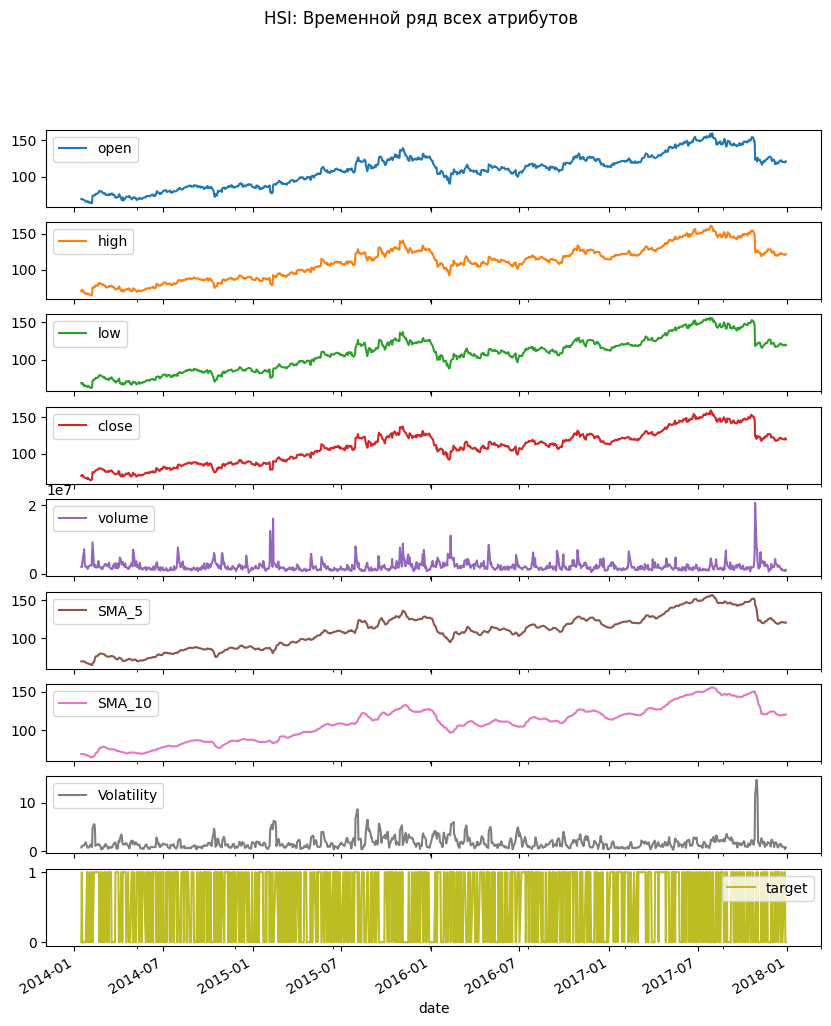

In [10]:
expe_data.set_index('date', inplace=True)
expe_data.index = pd.to_datetime(expe_data.index)

expe_data.plot(subplots=True, figsize=(10, 12), title='HSI: Временной ряд всех атрибутов')

Далее будем рассматривать цену закрытия

In [11]:
expe_data = expe_data[:-50]
full_expe_data = expe_data
expe_data = expe_data[-190:-30]

##Обучение моделей и прогноз

### Логистическая регрессия

Разделение данных на тестовую и обучающую выборку

In [12]:
from sklearn.model_selection import train_test_split

X_log = expe_data[['open', 'high', 'low' ,'SMA_5', 'SMA_10', 'Volatility']]
y_log = expe_data['target']

X_train, X_test, y_train, y_test = train_test_split(X_log, y_log, test_size=0.2, random_state=42, shuffle=False)

Масштабирование данных

In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [14]:
print(expe_data.columns)


Index(['symbol', 'open', 'high', 'low', 'close', 'volume', 'SMA_5', 'SMA_10',
       'Volatility', 'target'],
      dtype='object')


In [15]:
train_data = expe_data.iloc[:-len(X_test)]
test_data = expe_data.iloc[-len(X_test):]

In [16]:
print(train_data)

           symbol    open     high      low   close   volume    SMA_5  \
date                                                                    
2017-01-19   EXPE  119.72  119.830  118.410  118.84   991525  118.716   
2017-01-20   EXPE  119.75  120.290  118.680  119.92  1485728  119.098   
2017-01-23   EXPE  120.00  120.700  118.980  119.99  1369900  119.334   
2017-01-24   EXPE  120.37  120.555  119.270  120.22  1454478  119.662   
2017-01-25   EXPE  120.97  121.430  120.400  120.86  1058334  119.966   
...           ...     ...      ...      ...     ...      ...      ...   
2017-07-17   EXPE  154.30  154.440  152.160  152.73  1291421  152.416   
2017-07-18   EXPE  152.47  153.700  151.865  153.57   933731  153.142   
2017-07-19   EXPE  154.25  155.845  153.915  155.47  1007330  153.768   
2017-07-20   EXPE  155.22  155.980  153.960  154.63   953561  154.114   
2017-07-21   EXPE  153.91  154.950  152.930  153.94  1218922  154.068   

             SMA_10  Volatility  target  
date    

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Лучшие параметры: {'C': 0.01, 'class_weight': None, 'penalty': 'l1', 'solver': 'liblinear'}

Отчет о классификации:
              precision    recall  f1-score   support

           0       0.56      1.00      0.72        18
           1       0.00      0.00      0.00        14

    accuracy                           0.56        32
   macro avg       0.28      0.50      0.36        32
weighted avg       0.32      0.56      0.40        32

ROC-AUC: 0.50
MAE: 156.19, MSE: 24442.61, R2: -99321.36


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


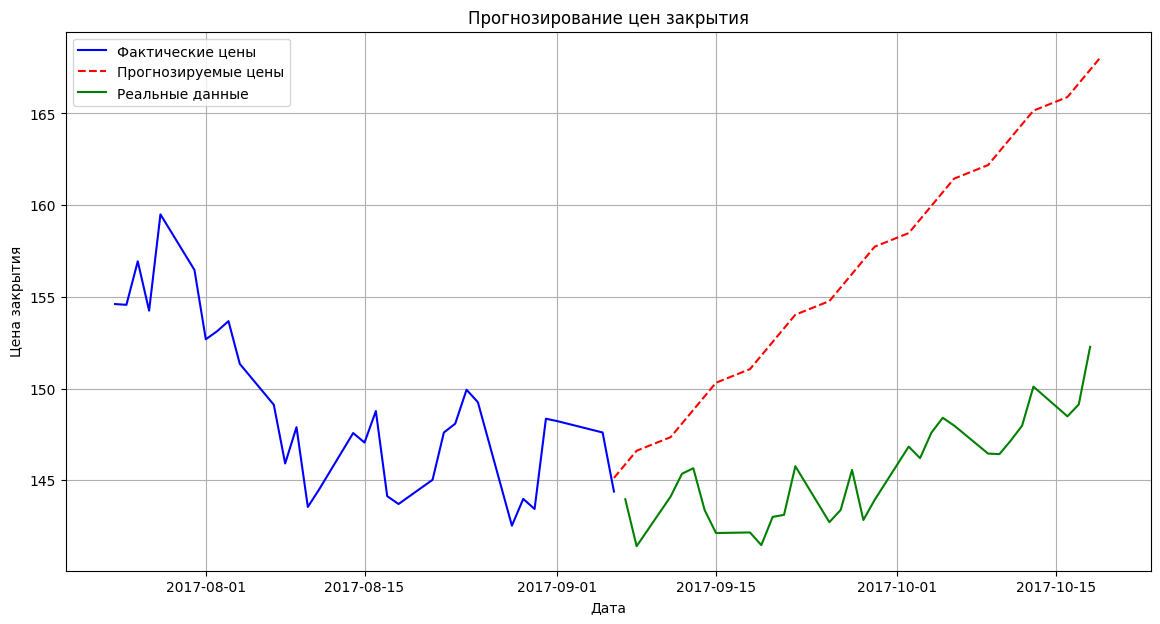

In [19]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

param_grid = {
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'],
    'C': [0.01, 0.1, 1, 10, 100],
    'class_weight': [None, 'balanced']
}


log_reg = LogisticRegression(max_iter=1000)
grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train_balanced, y_train_balanced)

best_model = grid_search.best_estimator_
print(f"Лучшие параметры: {grid_search.best_params_}")


y_pred = best_model.predict(X_test_scaled)
print("\nОтчет о классификации:")
print(classification_report(y_test, y_pred))

y_pred_prob = best_model.predict_proba(X_test_scaled)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC-AUC: {roc_auc:.2f}")

mean_delta_up = expe_data.loc[y_train.index[y_train == 1], 'close'].diff().mean()
mean_delta_down = expe_data.loc[y_train.index[y_train == 0], 'close'].diff().mean()

last_close = expe_data['close'].iloc[-1]
predicted_close = [last_close]
for pred in y_pred:
    if pred == 1:
        predicted_close.append(predicted_close[-1] + mean_delta_up)
    else:
        predicted_close.append(predicted_close[-1] + mean_delta_down)

predicted_close = predicted_close[1:]

mae_log = mean_absolute_error(y_test, predicted_close)
mse_log = mean_squared_error(y_test, predicted_close)
r2_log = r2_score(y_test, predicted_close)
print(f"MAE: {mae_log:.2f}, MSE: {mse_log:.2f}, R2: {r2_log:.2f}")

plt.figure(figsize=(14, 7))
plt.plot(expe_data.index[-len(y_test):], expe_data['close'][-len(y_test):], label='Фактические цены', color='blue')
plt.plot(pd.date_range(start=expe_data.index[-1], periods=len(predicted_close), freq='B'),
         predicted_close, label='Прогнозируемые цены', color='red', linestyle='--')
plt.plot(full_expe_data[-30:].index, full_expe_data['close'][-30:], label='Реальные данные', color='green')
plt.title('Прогнозирование цен закрытия')
plt.xlabel('Дата')
plt.ylabel('Цена закрытия')
plt.legend()
plt.grid()
plt.show()


Матрица ошибок

###Машин опорных векторов (SVR)

In [ ]:
X = expe_data[['open', 'high', 'low', 'SMA_5', 'SMA_10', 'Volatility']]
y = expe_data['close']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'epsilon': [0.1, 0.5],
    'gamma': ['scale', 'auto']
}

svr = SVR()
grid_search = GridSearchCV(estimator=svr, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

best_svr_model = grid_search.best_estimator_
print(f"Лучшие параметры: {grid_search.best_params_}")

Лучшие параметры: {'C': 10, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'linear'}


Средняя абсолютная ошибка (MAE): 0.6400
Среднеквадратичная ошибка (MSE): 0.6815
Коэффициент детерминации (R^2): 0.9658


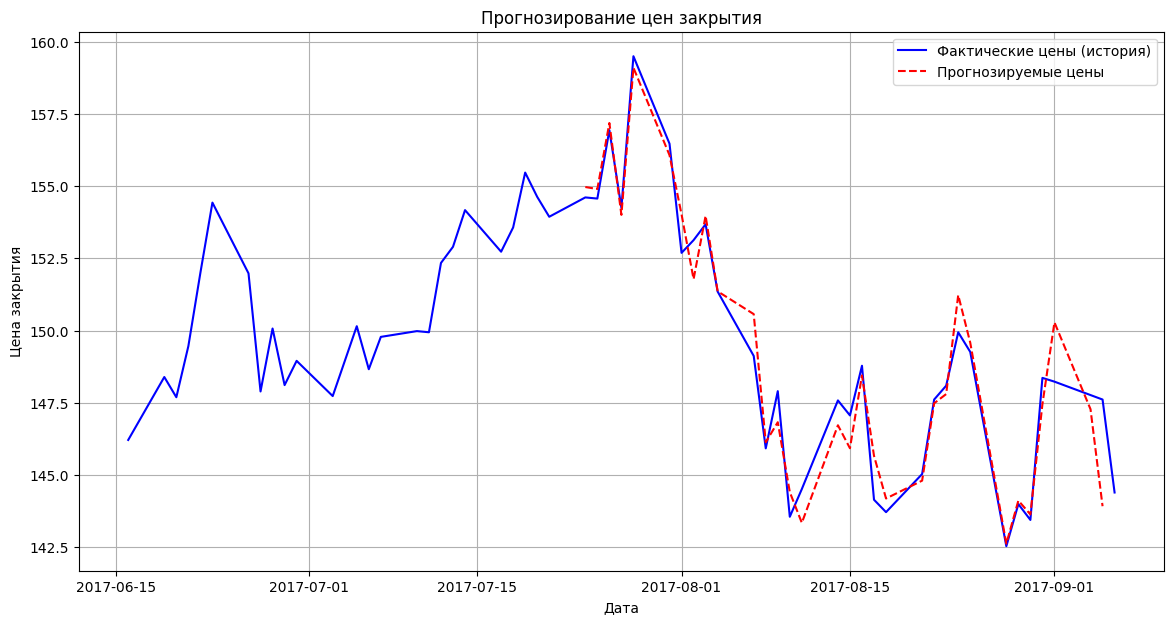

In [ ]:
y_pred = best_svr_model.predict(X_test_scaled)
predicted_close = best_svr_model.predict(X_test_scaled)

mae_svr = mean_absolute_error(y_test, y_pred)
mse_svr = mean_squared_error(y_test, y_pred)
r2_svr = r2_score(y_test, y_pred)
print(f"Средняя абсолютная ошибка (MAE): {mae_svr:.4f}")
print(f"Среднеквадратичная ошибка (MSE): {mse_svr:.4f}")
print(f"Коэффициент детерминации (R^2): {r2_svr:.4f}")

days_before_forecast = 25

historical_close = expe_data['close'][-(len(y_test) + days_before_forecast):]
forecast_dates = pd.date_range(start=historical_close.index[-len(y_test)-1], periods=len(y_test) + 1, freq='B')[1:]
forecast_close = predicted_close

plt.figure(figsize=(14, 7))
plt.plot(historical_close.index, historical_close, label='Фактические цены (история)', color='blue')
plt.plot(forecast_dates, forecast_close, label='Прогнозируемые цены', color='red', linestyle='--')
plt.title('Прогнозирование цен закрытия')
plt.xlabel('Дата')
plt.ylabel('Цена закрытия')
plt.legend()
plt.grid()
plt.show()

### Random Forest

In [ ]:
train_data = full_expe_data[:-60]
test_data = full_expe_data[-60:-30]

X_train = train_data[['open', 'high', 'low', 'SMA_5', 'SMA_10']].values
y_train = train_data['close'].values

X_test = test_data[['open', 'high', 'low', 'SMA_5', 'SMA_10']].values
y_test = test_data['close'].values

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

param_grid_rf = {
    'n_estimators': [10,50, 100],
    'max_depth': [None, 1, 5],
    'criterion': ['poisson', 'squared_error', 'absolute_error', 'friedman_mse'],
    'max_features': ['sqrt','log2'],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}

rf = RandomForestRegressor(random_state=42)

grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf,
                              cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search_rf.fit(X_train_scaled, y_train)

best_rf_model = grid_search_rf.best_estimator_
print(f"Лучшие параметры: {grid_search_rf.best_params_}")

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Лучшие параметры: {'criterion': 'absolute_error', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


MAE: 1.29, MSE: 3.15, R2: 0.83


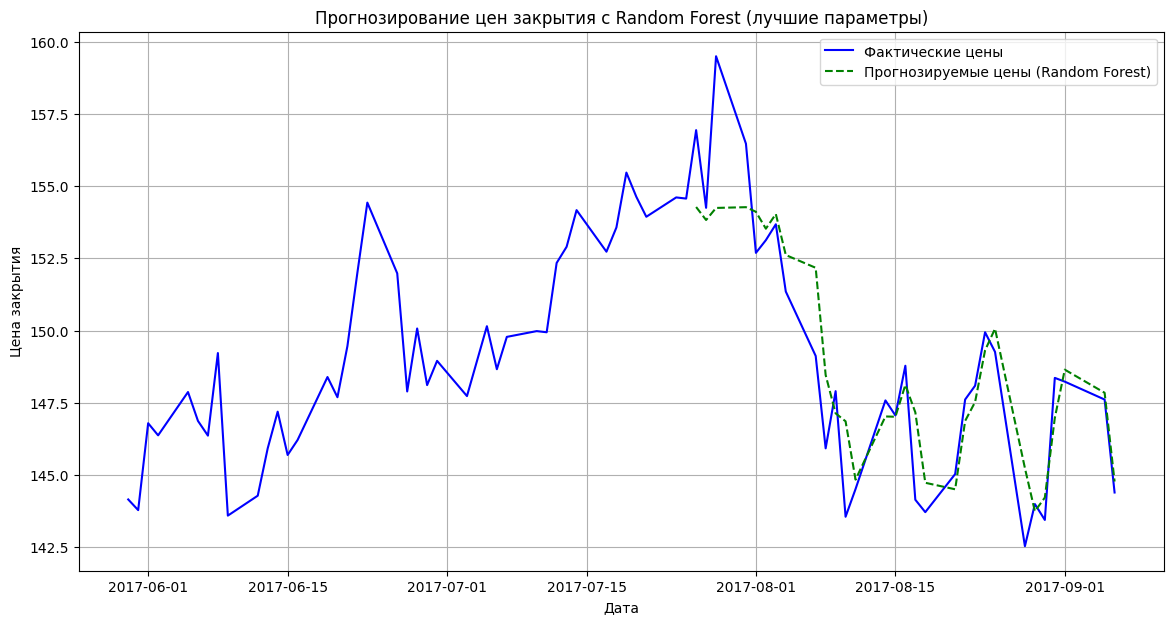

In [ ]:
y_pred_rf = best_rf_model.predict(X_test_scaled)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"MAE: {mae_rf:.2f}, MSE: {mse_rf:.2f}, R2: {r2_rf:.2f}")

plt.figure(figsize=(14, 7))

plt.plot(full_expe_data.index[-100:-30], full_expe_data['close'][-100:-30], label='Фактические цены', color='blue')

plt.plot(full_expe_data.index[-60:-30], y_pred_rf, label='Прогнозируемые цены (Random Forest)', color='green', linestyle='--')

plt.title('Прогнозирование цен закрытия с Random Forest (лучшие параметры)')
plt.xlabel('Дата')
plt.ylabel('Цена закрытия')
plt.legend()
plt.grid()
plt.show()

### XBoost

In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

X_train = train_data[['open', 'high', 'low', 'SMA_5', 'SMA_10']].values
y_train = train_data['close'].values

X_test = test_data[['open', 'high', 'low', 'SMA_5', 'SMA_10']].values
y_test = test_data['close'].values

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

dtrain = xgb.DMatrix(X_train_scaled, label=y_train)
dtest = xgb.DMatrix(X_test_scaled, label=y_test)

In [ ]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

param_grid_xgb = {
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5],
    'gamma': [0, 1, 5],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 2, 5]
}

grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid_xgb, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1)

grid_search_xgb.fit(X_train_scaled, y_train)

best_xgb_model = grid_search_xgb.best_estimator_
print(f"Лучшие параметры XGBoost: {grid_search_xgb.best_params_}")

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Лучшие параметры XGBoost: {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 0.1, 'reg_lambda': 1}


MAE: 1.20, MSE: 2.41, R2: 0.87


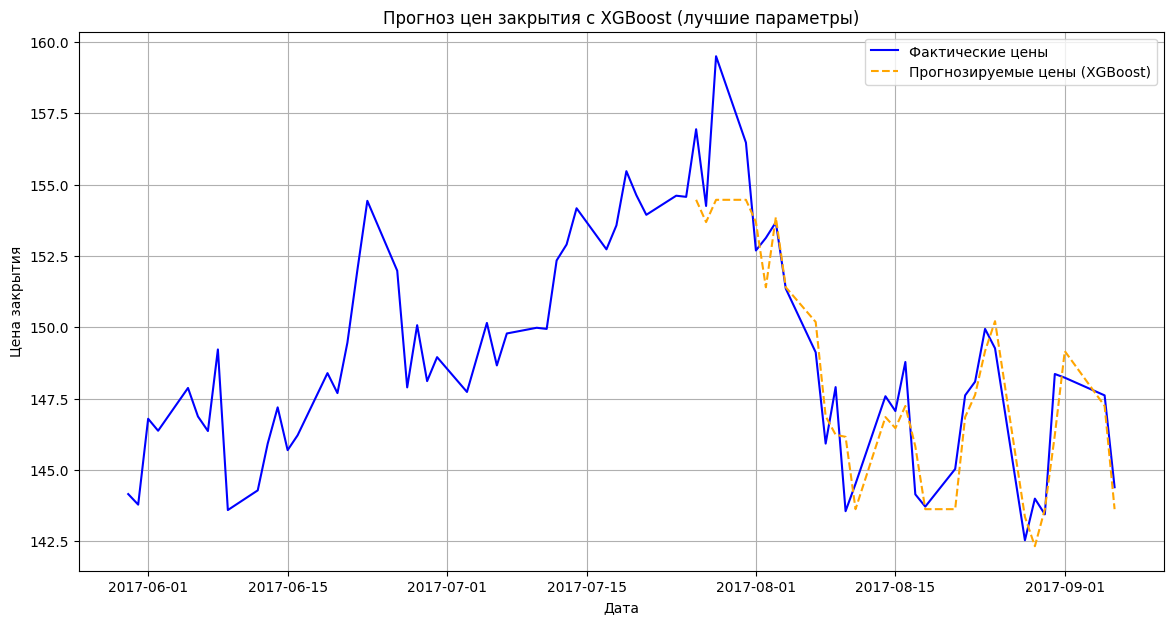

In [ ]:
y_pred_xgb = best_xgb_model.predict(X_test_scaled)

mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"MAE: {mae_xgb:.2f}, MSE: {mse_xgb:.2f}, R2: {r2_xgb:.2f}")

plt.figure(figsize=(14, 7))

# Фактические цены
plt.plot(full_expe_data.index[-100:-30], full_expe_data['close'][-100:-30], label='Фактические цены', color='blue')

# Прогнозируемые цены
plt.plot(full_expe_data.index[-60:-30], y_pred_xgb, label='Прогнозируемые цены (XGBoost)', color='orange', linestyle='--')

plt.title('Прогноз цен закрытия с XGBoost (лучшие параметры)')
plt.xlabel('Дата')
plt.ylabel('Цена закрытия')
plt.legend()
plt.grid()
plt.show()

### Наивный прогноз

<ipython-input-22-fb60c2158737>:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  naive_forecast = test_data['close'].shift(1).fillna(method='bfill')


Наивный метод:
MAE: 2.19, MSE: 7.76, R2: 0.59


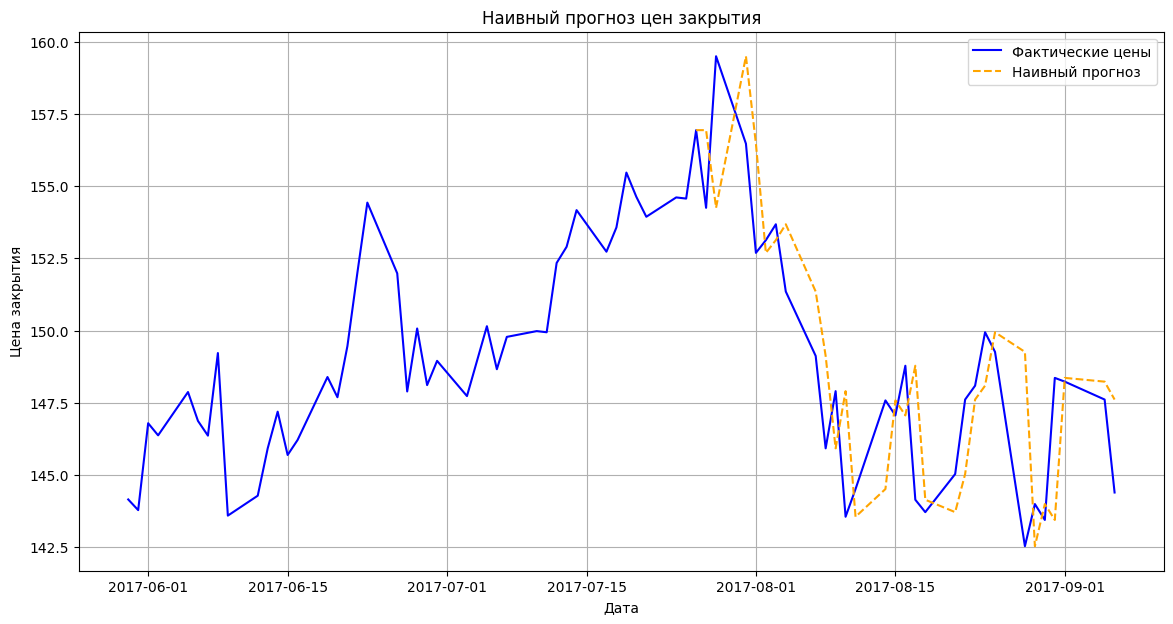

In [ ]:
naive_forecast = test_data['close'].shift(1).fillna(method='bfill')

mae_naive = mean_absolute_error(test_data['close'], naive_forecast)
mse_naive = mean_squared_error(test_data['close'], naive_forecast)
r2_naive = r2_score(test_data['close'], naive_forecast)

print(f"Наивный метод:")
print(f"MAE: {mae_naive:.2f}, MSE: {mse_naive:.2f}, R2: {r2_naive:.2f}")

plt.figure(figsize=(14, 7))

plt.plot(full_expe_data.index[-100:-30], full_expe_data['close'][-100:-30], label='Фактические цены', color='blue')

plt.plot(test_data.index, naive_forecast, label='Наивный прогноз', color='orange', linestyle='--')

plt.title('Наивный прогноз цен закрытия')
plt.xlabel('Дата')
plt.ylabel('Цена закрытия')
plt.legend()
plt.grid()
plt.show()

## Сравнение моделей по метрикам MAE, MSE, R2

In [ ]:
metrics = {
    'Model': ['Support Vector Machine', 'Random Forest', 'XGBoost', 'Naive Forecast'],
    'MAE': [mae_svr, mae_rf, mae_xgb, mae_naive],
    'MSE': [mse_svr, mse_rf, mse_xgb, mse_naive],
    'R2': [r2_svr, r2_rf, r2_xgb, r2_naive]
}

metrics_df = pd.DataFrame(metrics)

from IPython.display import display
display(metrics_df)


,Model,MAE,MSE,R2
0,Support Vector Machine,0.640012,0.681528,0.965752
1,Random Forest,1.289567,3.146772,0.834404
2,XGBoost,1.203674,2.411213,0.873112
3,Naive Forecast,2.190333,7.758523,0.591716


Исходя из метрик MAE, MSE, R2 можем увидеть, что наибольшую точность показывает модель SVM(машина опорных векторов).

XGBoost также продемонстрировал стабильные результаты, превосходя Random Forest по метрикам точности.

Random Forest оказался менее точным, чем SVM и XGBoost, но всё же значительно лучше наивного метода.

Наивный прогноз служит базовым ориентиром, показывая, что модели машинного обучения значительно улучшают точность прогнозирования.

## Анализ важности признаков

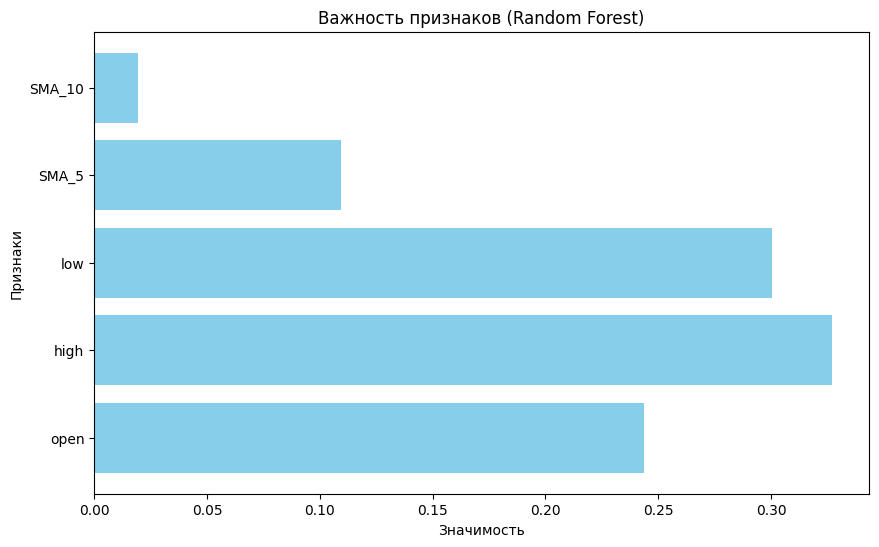

In [ ]:
feature_importances_rf = best_rf_model.feature_importances_
features = ['open', 'high', 'low', 'SMA_5', 'SMA_10']

# Построение графика
plt.figure(figsize=(10, 6))
plt.barh(features, feature_importances_rf, color='skyblue')
plt.title('Важность признаков (Random Forest)')
plt.xlabel('Значимость')
plt.ylabel('Признаки')
plt.show()

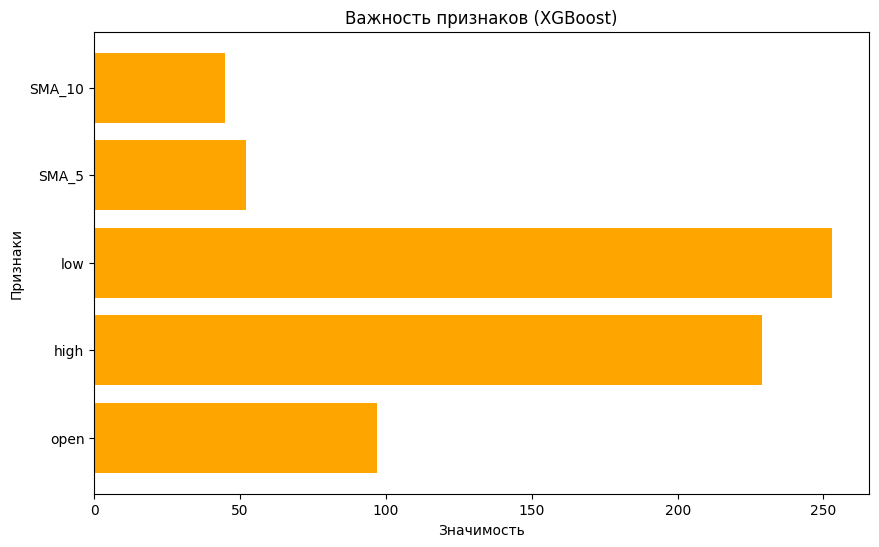

In [ ]:
from xgboost import plot_importance

feature_importances_xgb = best_xgb_model.get_booster().get_score(importance_type='weight')

import pandas as pd
importance_df = pd.DataFrame({
    'Признак': feature_names,
    'Значимость': [feature_importances_xgb.get(f'f{i}', 0) for i in range(len(feature_names))]
})

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Признак'], importance_df['Значимость'], color='orange')
plt.title('Важность признаков (XGBoost)')
plt.xlabel('Значимость')
plt.ylabel('Признаки')
plt.show()

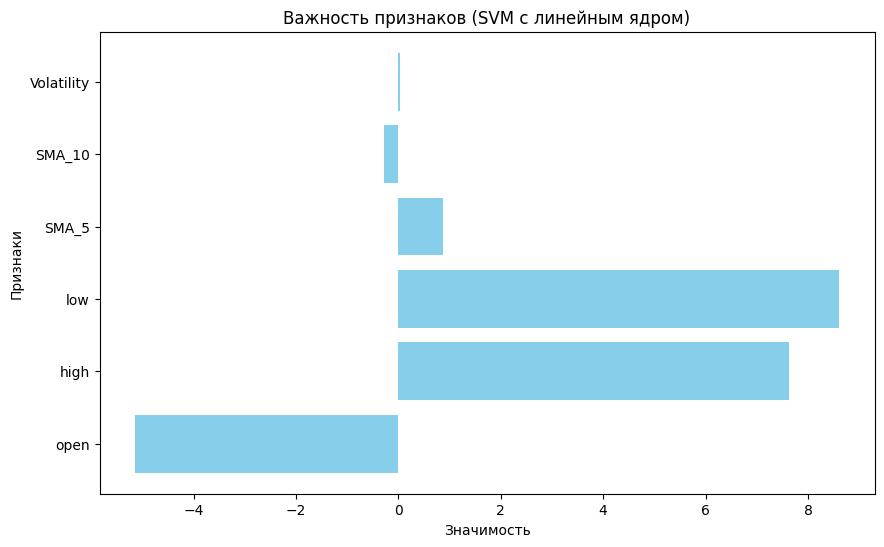

In [ ]:
if best_svr_model.kernel == 'linear':
    coef_svr = best_svr_model.coef_.ravel()
    features = ['open', 'high', 'low', 'SMA_5', 'SMA_10', 'Volatility']

    plt.figure(figsize=(10, 6))
    plt.barh(features, coef_svr, color='skyblue')
    plt.title('Важность признаков (SVM с линейным ядром)')
    plt.xlabel('Значимость')
    plt.ylabel('Признаки')
    plt.show()
else:
    print("Важность признаков недоступна для нелинейных ядер SVM.")

Наиболее важными для моделей признаками являются признаки high, low, open

В ходе выполнения данной работы, были обучены модели:
Логистическая регрессия

Машина опорных векторов

Модель случайного леса (Random Forest)

Градиентный бустинг (например, XGBoost)

С помощью данных моделей построены графики прогноза цен закрытия. В результате можно прийти к выводу, что методы машинного обучения показали высокую точность и адаптивность в прогнозировании цен закрытия.

Наибольшую эффективность показали модели SVM и XGBoost.
